In [28]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import kagglehub

In [3]:
def get_mig_uuids():
    result = subprocess.run(['nvidia-smi', '-L'], stdout=subprocess.PIPE, text=True)
    if result.returncode != 0:
        raise RuntimeError(f"Command 'nvidia-smi -L' failed with exit code {result.returncode}")
    output = result.stdout
    mig_uuid_pattern = re.compile(r'MIG-[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}')
    mig_uuids = mig_uuid_pattern.findall(output)
    return mig_uuids
def set_cuda_visible_devices(mig_uuids):
    mig_uuids_str = ','.join(mig_uuids)
    os.environ['CUDA_VISIBLE_DEVICES'] = mig_uuids_str
    print(f"CUDA_VISIBLE_DEVICES set to: {mig_uuids_str}")
    mig_uuids = get_mig_uuids()
    if mig_uuids:
        set_cuda_visible_devices(mig_uuids)
    else:
        print("No MIG devices found.")

In [5]:
# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [6]:
labels = ['glioma', 'notumor', 'meningioma', 'pituitary']

class_map = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}

inverse_class_map = {
    0: 'notumor',
    1: 'glioma',
    2: 'meningioma',
    3: 'pituitary'
}

In [7]:
h, w = 224, 224
batch_size = 32
epochs = 40
learning = 0.001

In [8]:
IMAGES = []
LABELS = []
train_path = path + '/Training'

for label in labels:
    folderPath = os.path.join(train_path, label)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (h, w))  # Resize image
        IMAGES.append(img)
        LABELS.append(class_map[label])

# Convert lists to NumPy arrays
X_train = np.array(IMAGES)
y_train = np.array(LABELS)


100%|██████████| 1457/1457 [00:02<00:00, 600.32it/s]


In [12]:
IMAGES = []
LABELS = []
test_path = path + '/Testing'

for label in labels:
    folderPath = os.path.join(test_path, label)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (h, w))  # Resize image
        IMAGES.append(img)
        LABELS.append(class_map[label])

# Convert lists to NumPy arrays
X_test = np.array(IMAGES)
y_test = np.array(LABELS)


100%|██████████| 300/300 [00:00<00:00, 649.45it/s]


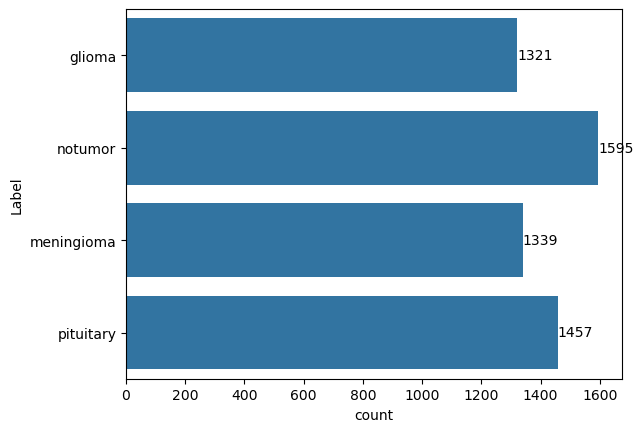

In [14]:
y_train_labels = [inverse_class_map[label] for label in y_train]
train_dataframe = pd.DataFrame({'Label': y_train_labels})

x = sns.countplot(data=train_dataframe, y="Label")
for container in x.containers:
    x.bar_label(container)
    
plt.show()

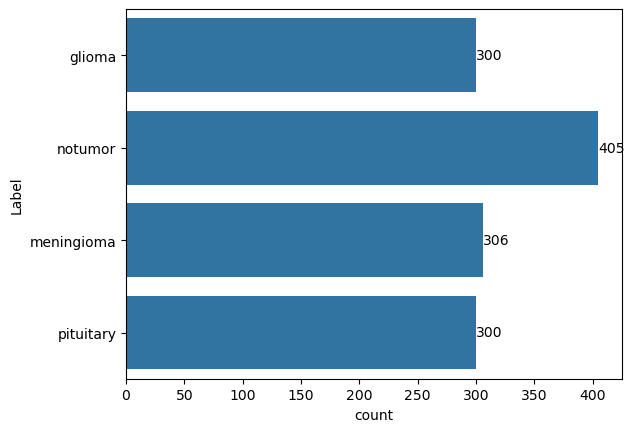

In [15]:
y_test_labels = [inverse_class_map[label] for label in y_test]
test_dataframe = pd.DataFrame({'Label': y_test_labels})

x = sns.countplot(data=test_dataframe, y="Label")
for container in x.containers:
    x.bar_label(container)
    
plt.show()

In [16]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

X_train = X_train.reshape(X_train.shape[0], h, w, 3)  # Assuming 3 channels (RGB)
X_test = X_test.reshape(X_test.shape[0], h, w, 3)

In [17]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-23 04:59:31.089695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8098 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:65:00.0, compute capability: 8.0


In [20]:
model.compile(Adamax(learning_rate= learning),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,107,652 (19.48 MB)

 Trainable params: 5,107,652 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2, 
    shear_range=0.2,
    zoom_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest'
)

In [23]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [24]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs, 
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

results = model.evaluate(X_test, y_test)
print("Accuracy:", results[1])

Epoch 1/40


/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1740286802.708519     249 service.cc:146] XLA service 0x7fb1fc0057a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740286802.708563     249 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.10gb, Compute Capability 8.0
2025-02-23 05:00:02.782947: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-23 05:00:02.970506: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  2/179 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.2812 - loss: 1.6937 - precision: 0.1034 - recall: 0.0469          

I0000 00:00:1740286812.633542     249 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 314ms/step - accuracy: 0.3834 - loss: 1.2739 - precision: 0.6572 - recall: 0.1078 - val_accuracy: 0.6178 - val_loss: 1.0274 - val_precision: 0.7161 - val_recall: 0.4714
Epoch 2/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 239ms/step - accuracy: 0.6285 - loss: 0.9045 - precision: 0.7499 - recall: 0.4290 - val_accuracy: 0.6552 - val_loss: 0.8633 - val_precision: 0.7566 - val_recall: 0.5645
Epoch 3/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 239ms/step - accuracy: 0.6818 - loss: 0.7948 - precision: 0.7670 - recall: 0.5423 - val_accuracy: 0.6789 - val_loss: 0.8507 - val_precision: 0.7315 - val_recall: 0.5568
Epoch 4/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 238ms/step - accuracy: 0.7129 - loss: 0.7347 - precision: 0.7809 - recall: 0.6151 - val_accuracy: 0.7124 - val_loss: 0.6997 - val_precision: 0.7756 - val_recall: 0.6247
Epoch 5/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 239ms/step - accuracy: 0.7537 - loss: 0.6574 - precision: 0.8094 - recall: 0.6659 - val_accuracy: 0.6545 - val_loss

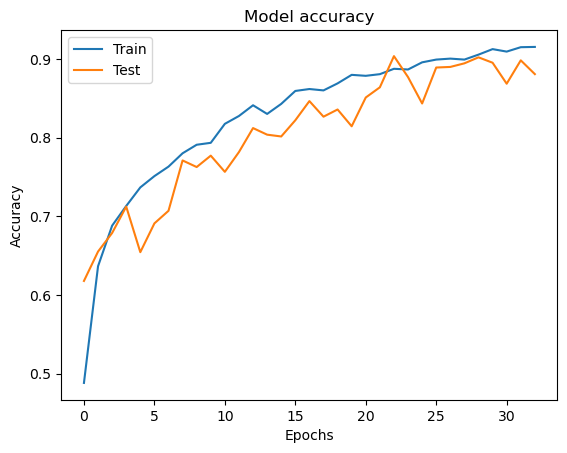

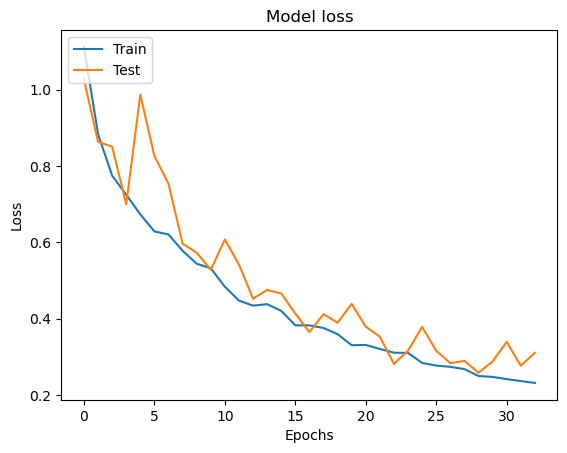

In [25]:
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [26]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8806 - loss: 0.2896 - precision: 0.8849 - recall: 0.8785
Test Accuracy: 90.39%
Test Loss: 0.2814


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


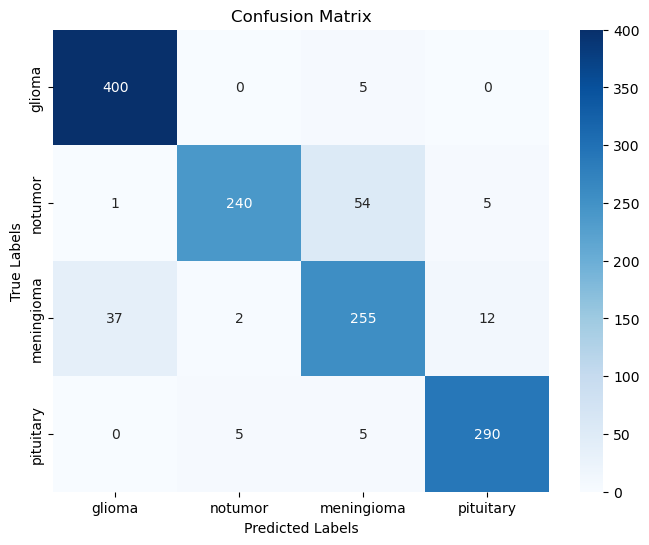

Classification Report:
               precision    recall  f1-score   support

      glioma       0.91      0.99      0.95       405
     notumor       0.97      0.80      0.88       300
  meningioma       0.80      0.83      0.82       306
   pituitary       0.94      0.97      0.96       300

    accuracy                           0.90      1311
   macro avg       0.91      0.90      0.90      1311
weighted avg       0.91      0.90      0.90      1311



In [30]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=labels)
print("Classification Report:\n", report)